#### Import Libraries 

In [40]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.stats import norm
from math import exp, sqrt
import math

#### AmPutLattice Function

In [2]:
def AmPutLattice(S0, K, r, T, sigma, N):
    # Precompute invariant quantities
    deltaT = T/N
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1/u
    p = (np.exp(r*deltaT) - d)/(u-d)
    discount = np.exp(-r*deltaT)
    p_u = discount*p
    p_d = discount*(1-p)
    
    # set up S values
    SVals = np.zeros(2*N+1)
    SVals[N] = S0
    for i in range(1, N+1):
        SVals[N+i] = u*SVals[N+i-1]
        SVals[N-i] = d*SVals[N-i+1]
    
    # set up terminal values
    PVals = np.zeros(2*N+1)
    for i in range(0, 2*N+1, 2):
        PVals[i] = max(K-SVals[i], 0)
    
    # work backwards
    for tau in range(1, N+1):
        for i in range(tau+1, 2*N-tau+1, 2):
            hold = p_u*PVals[i+1] + p_d*PVals[i-1]
            PVals[i] = max(hold, K-SVals[i])
    
    price = PVals[N]
    print(sigma)
    return round(price,4)

#### AmPutLattice Test

In [3]:
S0 = 50
K = 50
r = 0.05
T = 5/12
sigma = 0.4
N = 1000
print(AmPutLattice(S0, K, r, T, sigma, N))


0.4
4.6697


#### Asian MC Function

In [23]:
def AssetPaths(S0, mu, sigma, T, NSteps, NRepl):
    SPaths = np.zeros((NRepl, NSteps+1))
    SPaths[:, 0] = S0
    dt = T/NSteps
    nudt = (mu-0.5*sigma**2)*dt
    sidt = sigma*np.sqrt(dt)
    for i in range(NRepl):
        for j in range(NSteps):
            SPaths[i, j+1] = SPaths[i, j]*np.exp(nudt + sidt*np.random.normal())
    return SPaths

In [24]:
def AsianMC(S0, K, r, T, sigma, NSamples, NRepl):
    Payoff = np.zeros((NRepl, ))
    for i in range(NRepl):
        Path = AssetPaths(S0, r, sigma, T, NSamples, 1)
        Payoff[i] = max(0, np.mean(Path[0, 1:(NSamples+1)]) - K)
    P1 = np.mean(np.exp(-r*T)*Payoff)
    se = np.std(np.exp(-r*T)*Payoff, ddof=1)/np.sqrt(NRepl)
    alpha = 0.05
    CI1 = norm.interval(1-alpha, loc=P1, scale=se)
    return 'P1:', P1, 'CI:' , CI1

#### AsianMCCV Function

In [25]:
def AsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,NPilot):
    # pilot replications to set control parameter
    TryPath=AssetPaths(S0,r,sigma,T,NSamples,NPilot)
    StockSum = np.sum(TryPath,1)
    PP = np.mean(TryPath[:,1:(NSamples+1)],1)
    TryPayoff = np.exp(-r*T) * np.maximum(0, PP - K)
    MatCov = np.cov(StockSum, TryPayoff)
    c = - MatCov[0,1] / np.var(StockSum)
    dt = T / NSamples
    ExpSum = S0 * (1 - np.exp((NSamples + 1)*r*dt)) / (1 - np.exp(r*dt))
    
    # MC run with control variates and bootstrapping
    ControlVars = np.zeros(NRepl)
    for i in range(NRepl):
        StockPath = AssetPaths(S0,r,sigma,T,NSamples,1)
        Payoff = np.exp(-r*T) * np.maximum(0, np.mean(StockPath[:,1:(NSamples+1)],1) - K)
        ControlVars[i] = Payoff + c * (np.sum(StockPath) - ExpSum)
    
    # bootstrap for confidence interval
    resamples = np.random.choice(ControlVars, size=(NRepl, NRepl), replace=True)
    bootstrap_means = np.mean(resamples, axis=1)
    ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])
    P2 = np.mean(ControlVars)
    CI2 = (ci_lower, ci_upper)
    return 'P2:', P2, "CI2:", CI2


#### GeometricAsian Function

In [26]:
def GeometricAsian(S0, K, r, T, sigma, delta, NSamples):
    dT = T / NSamples
    nu = r - sigma**2/2 - delta
    a = np.log(S0) + nu * dT * NSamples + 0.5 * nu * (T - dT * NSamples)
    b = sigma**2 * dT * NSamples * (NSamples + 1) * (2 * NSamples + 1) / 6 / NSamples**2
    x = (a - np.log(K) + b) / np.sqrt(b)
    P = np.exp(-r * T) * (np.exp(a + b/1.372) * norm.cdf(x) - K * norm.cdf(x - np.sqrt(b)))
    return P
def AssetPaths1(S0, r, sigma, T, NSamples, NRepl):
    dt = T / NSamples
    nu = r - 0.5 * sigma**2
    S = np.zeros((NSamples + 1, NRepl))
    S[0] = S0
    for t in range(1, NSamples + 1):
        S[t] = S[t-1] * np.exp(nu * dt + sigma * np.sqrt(dt) * np.random.randn(NRepl))
    return S

#### AsianMCGeoCV Function

In [27]:
def AsianMCGeoCV(S0, K, r, T, sigma, NSamples, NRepl, NPilot):
    # precompute quantities
    DF = np.exp(-r * T)
    GeoExact = GeometricAsian(S0, K, r, T, sigma, 0, NSamples)
    # pilot replications to set control parameter
    GeoPrices = np.zeros(NPilot)
    AriPrices = np.zeros(NPilot)
    for i in range(NPilot):
        Path = AssetPaths1(S0, r, sigma, T, NSamples, 1)
        GeoPrices[i] = DF * max(0, np.power(np.prod(Path[1:(NSamples+1)]), 1/NSamples) - K)
        AriPrices[i] = DF * max(0, np.mean(Path[1:(NSamples+1)]) - K)
    MatCov = np.cov(GeoPrices, AriPrices)
    c = - MatCov[0, 1] / np.var(GeoPrices, ddof=1)
    # MC run
    ControlVars = np.zeros(NRepl)
    for i in range(NRepl):
        Path = AssetPaths1(S0, r, sigma, T, NSamples, 1)
        GeoPrice = DF * max(0, np.power(np.prod(Path[1:(NSamples+1)]), 1/NSamples) - K)
        AriPrice = DF * max(0, np.mean(Path[1:(NSamples+1)]) - K)
        ControlVars[i] = AriPrice + c * (GeoPrice - GeoExact)
    P = np.mean(ControlVars)
    # two-sided confidence interval
    bootstrap_means = np.zeros(NRepl)
    for i in range(NRepl):
        resamples = np.random.choice(ControlVars, size=NRepl, replace=True)
        bootstrap_means[i] = np.mean(resamples)
    ci_lower, ci_upper = np.percentile(bootstrap_means, [5, 95])
    CI = (ci_lower, ci_upper)
    return "P3:", P, "CI3:",  CI

#### Asian Compare Test

In [28]:

np.random.seed(0)
S0 = 50
K = 55
r = 0.05
sigma = 0.4
T = 1
NSamples = 12
NRepl = 9000
NPilot = 1000
print(AsianMC(S0, K, r, T, sigma, NSamples, NRepl+NPilot))
print(AsianMCCV(S0,K,r,T,sigma,NSamples,NRepl,NPilot))
print(AsianMCGeoCV(S0, K, r, T, sigma, NSamples, NRepl, NPilot))


('P1:', 3.458078439249151, 'CI:', (3.3166100043035827, 3.599546874194719))
('P2:', 3.42226384462163, 'CI2:', (3.3455610180882926, 3.4995921816571456))
('P3:', 3.45149915113709, 'CI3:', (3.442903566841964, 3.4604285982583365))


#### DOPutMC Function

In [60]:
def blsprice(S0, K, r, T, sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Call = S0 * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    Put = K*np.exp(-r*T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return Call, Put

In [61]:
def DOPutMC(S0, K, r, T, sigma, Sb, NSteps, NRepl):
    np.random.seed(0)
    Call, Put = blsprice(S0, K, r, T, sigma)
    Payoff = np.zeros(NRepl)
    NCrossed = 0
    for i in range(NRepl):
        Path = AssetPaths1(S0, r, sigma, T, NSteps, 1)
        crossed = np.any(Path <= Sb)
        if not crossed:
            Payoff[i] = max(0, K - Path[NSteps])
        else:
            Payoff[i] = 0
            NCrossed += 1
    P, CI = norm.fit(np.exp(-r*T) * Payoff)
    return  P, CI 


#### DOPutMC Test

In [62]:
S0 = 50
K = 50
r = 0.1
T = 2/12
sigma = 0.4
Sb = 40
NSteps = 60
NRepl = 50000

P, CI = DOPutMC(S0, K, r, T, sigma, Sb, NSteps, NRepl)
print("sigma:" ,sigma)
print("P =", P)

sigma: 0.4
P = 1.3593543709948674


#### DOPutMCCond Function

In [63]:
np.random.seed(0)
def DOPutMCCond(S0, K, r, T, sigma, Sb, NSteps, NRepl):
    dt = T/NSteps
    Call, Put = blsprice(S0, K, r, T, sigma)
    
    # Generate asset paths and payoffs for the down and in option
    NCrossed = 0
    Payoff = np.zeros(NRepl)
    Times = np.zeros(NRepl)
    StockVals = np.zeros(NRepl)
    for i in range(NRepl):
        Path = AssetPaths(S0, r, sigma, T, NSteps, 1)
        try:
            tcrossed = np.min(np.where(Path <= Sb)[1])
        except ValueError:
            tcrossed = np.nan
        if not np.isnan(tcrossed):
            NCrossed += 1
            Times[NCrossed-1] = (tcrossed-1) * dt
            StockVals[NCrossed-1] = Path[0,tcrossed]
    
    if NCrossed > 0:
        Caux, Paux = blsprice(StockVals[:NCrossed], K, r, T-Times[:NCrossed], sigma)
        Payoff[:NCrossed] = np.exp(-r*Times[:NCrossed]) * Paux
    
    Pdo, CI = norm.fit(Put - Payoff)
    return Pdo, CI, NCrossed


#### DOPutMCCond Test

In [64]:

# Test the function
S0 = 50
K = 52
r = 0.1
T = 2/12
sigma = 0.4
Sb = 30
NSteps = 60
NRepl = 200000
Pdo, CI, NCrossed = DOPutMCCond(S0, K, r, T, sigma, Sb, NSteps, NRepl)

print("sigma = ", sigma)
print("Pdo ", Pdo)


sigma =  0.4
Pdo  3.8632978794995254


#### DOPutMCCondIS Function

In [65]:
def DOPutMCCondIS(S0, K, r, T, sigma, Sb, NSteps, NRepl, bp):
    dt = T / NSteps
    nudt = (r - 0.5 * sigma ** 2) * dt
    b = bp * nudt
    sidt = sigma * math.sqrt(dt)
    Call, Put = blsprice(S0, K, r, T, sigma)
    NCrossed = 0
    Payoff = np.zeros(NRepl)
    Times = np.zeros(NRepl)
    StockVals = np.zeros(NRepl)
    ISRatio = np.zeros(NRepl)
    for i in range(NRepl):
        vetZ = nudt - b + sidt * np.random.randn(NSteps)
        LogPath = np.cumsum(np.concatenate(([np.log(S0)], vetZ)))
        Path = np.exp(LogPath)
        jcrossed = None
        indices = np.where(Path <= Sb)[0]
        if len(indices) > 0:
            jcrossed = np.min(indices)
        if jcrossed is not None:
            NCrossed += 1
            TBreach = jcrossed - 1
            Times[NCrossed - 1] = TBreach * dt
            StockVals[NCrossed - 1] = Path[jcrossed]
            ISRatio[NCrossed - 1] = np.exp(
                TBreach * b ** 2 / 2 / sigma ** 2 / dt + 
                b / sigma ** 2 / dt * np.sum(vetZ[0:TBreach]) -
                TBreach * b / sigma ** 2 * (r - sigma ** 2 / 2)
            )
    if NCrossed > 0:
        Caux, Paux = blsprice(StockVals[0:NCrossed], K, r,
                              T - Times[0:NCrossed], sigma)
        Payoff[0:NCrossed] = np.exp(-r * Times[0:NCrossed]) * Paux * ISRatio[0:NCrossed]
    Pdo, CI = norm.fit(Put - Payoff)
    return Pdo, CI, NCrossed


#### DOPutMCCondIS Test

In [66]:
S0 = 50
K = 52
r = 0.1
T = 2 / 12
sigma = 0.4
Sb = 30
NSteps = 60
NRepl = 200000

b0 = 0
np.random.seed(0)
Pdo, CI, NCrossed = DOPutMCCondIS(S0, K, r, T, sigma, Sb, NSteps, NRepl, b0)
print(Pdo)

b0 = 20
np.random.seed(0)
Pdo, CI, NCrossed = DOPutMCCondIS(S0, K, r, T, sigma, Sb, NSteps, NRepl, b0)
print(Pdo)

b0 = 50
np.random.seed(0)
Pdo, CI, NCrossed = DOPutMCCondIS(S0, K, r, T, sigma, Sb, NSteps, NRepl, b0)
print(Pdo)

3.8632978794995254
3.862039640573587
3.8577011795486147


#### EuCallTrinomial Function

In [67]:
def EuCallTrinomial(S0, K, r, T, sigma, N, deltaX):
    # Precompute invariant quantities
    deltaT = T/N
    nu = r - 0.5*sigma**2
    discount = np.exp(-r*deltaT)
    p_u = discount*0.5*((sigma**2*deltaT+nu**2*deltaT**2)/deltaX**2 + nu*deltaT/deltaX)
    p_m = discount*(1 - (sigma**2*deltaT+nu**2*deltaT**2)/deltaX**2)
    p_d = discount*0.5*((sigma**2*deltaT+nu**2*deltaT**2)/deltaX**2 - nu*deltaT/deltaX)
    
    # set up S values (at maturity)
    Svals = np.zeros(2*N+1)
    Svals[0] = S0*np.exp(-N*deltaX)
    for j in range(1, 2*N+1):
        Svals[j] = np.exp(deltaX)*Svals[j-1]
    
    # set up lattice and terminal values
    Cvals = np.zeros((2*N+1, 2))
    t = N % 2
    for j in range(2*N+1):
        Cvals[j,t] = max(Svals[j]-K, 0)
    
    for t in range(N-1, -1, -1):
        know = t % 2
        knext = (t+1) % 2
        for j in range(N-t, N+t+1):
            Cvals[j,know] = p_d*Cvals[j-1,knext] + p_m*Cvals[j,knext] + p_u*Cvals[j+1,knext]
    
    price = Cvals[N,0]
    return price

#### EuCallTrinomial test 

In [68]:
# Example usage
S0 = 100
K = 100
r = 0.06
T = 1
sigma = 0.3
N = 100
deltaX = 0.2
#print("Sigma:" ,sigma)
print("Sigma:" ,sigma,"\n", EuCallTrinomial(S0,K,r,T,sigma,N,deltaX))

deltaX = 0.5
print("DeltaX = ",deltaX, "\n", EuCallTrinomial(S0,K,r,T,sigma,N,deltaX))

deltaX = sigma*np.sqrt(T/N)
print(EuCallTrinomial(S0,K,r,T,sigma,N,deltaX))

N = 1000
deltaX = sigma*np.sqrt(T/N)
print("N= ",N, "\n",EuCallTrinomial(S0,K,r,T,sigma,N,deltaX))

Sigma: 0.3 
 14.0715253404263
DeltaX =  0.5 
 10.934453552002916
14.686913681699451
N=  1000 
 14.714053134172694


#### Plot BSL Function

In [69]:
def PlotBLS(S0, X, r , sigma):

    for T in np.arange(2, -0.25, -0.24999):
        plt.plot(S0, norm.cdf((np.log(S0/X) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * S0 
                 - norm.cdf((np.log(S0/X) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * X * np.exp(-r*T))

    plt.axis([30, 70, -5, 35])
    plt.grid(True)
    plt.show()

#### Plot BSL 

C:\Users\Jehad\AppData\Local\Temp\ipykernel_11824\3890009288.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(S0, norm.cdf((np.log(S0/X) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * S0
C:\Users\Jehad\AppData\Local\Temp\ipykernel_11824\3890009288.py:5: RuntimeWarning: invalid value encountered in sqrt
  - norm.cdf((np.log(S0/X) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))) * X * np.exp(-r*T))


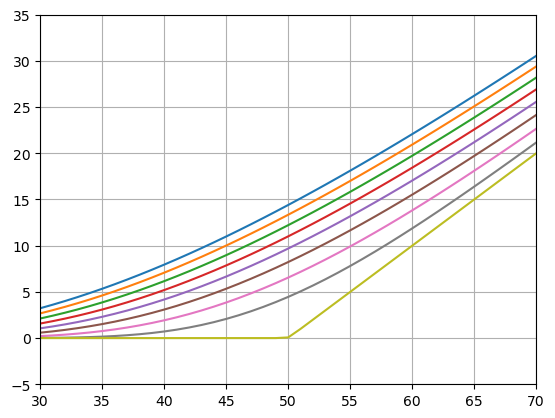

In [70]:
S0 = np.arange(30, 71, 1)
X = 50
r = 0.08
sigma = 0.4
PlotBLS(S0, X, r , sigma)


#### SmartEurLattice Function

In [71]:
def SmartEurLattice(S0, K, r, T, sigma, N):
    # Precompute invariant quantities
    deltaT = T/N
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1/u
    p = (np.exp(r*deltaT) - d)/(u-d)
    discount = np.exp(-r*deltaT)
    p_u = discount*p
    p_d = discount*(1-p)
    
    # set up S values
    SVals = np.zeros(2*N+1)
    SVals[0] = S0*d**N
    for i in range(1, 2*N+1):
        SVals[i] = u*SVals[i-1]
        
    # set up terminal CALL values
    CVals = np.zeros(2*N+1)
    for i in range(0, 2*N+1, 2):
        CVals[i] = max(SVals[i]-K, 0)
    
    # work backwards
    for tau in range(N-1, -1, -1):
        for i in range(0, 2*tau+1):
            SVals[i] = d*SVals[i+1]
            CVals[i] = p_u*CVals[i+2] + p_d*CVals[i]
            CVals[i] = max(CVals[i], SVals[i]-K)
            
    return CVals[0]

#### SmartEurLattice Test

In [72]:
def blsprice1(S0, K, r, T, sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    Nd1 = 0.5 + 0.5*np.math.erf(d1/np.sqrt(2))
    Nd2 = 0.5 + 0.5*np.math.erf(d2/np.sqrt(2))
    return S0*Nd1 - K*np.exp(-r*T)*Nd2

In [73]:
S0 = 50
K = 50
r = 0.1
T = 5/12
sigma = 0.4
N = 50

BlsC = blsprice1(S0, K, r, T, sigma)
print(BlsC)


6.116508129330871


#### SmartEurLattice Accuracy 

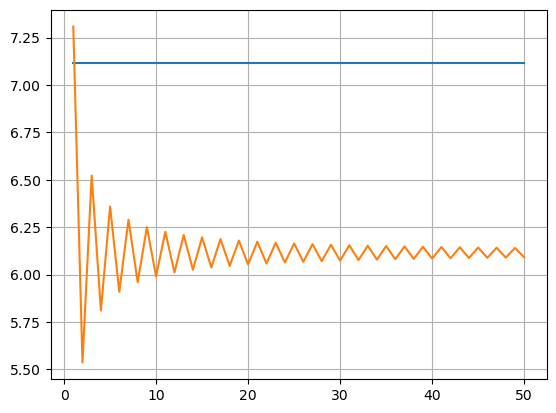

In [74]:
S0 = 50
K = 50
r = 0.1
T = 5/12
sigma = 0.4
N = 50

BlsC = blsprice1(S0, K, r, T, sigma)
LatticeC = np.zeros(N)
for i in range(N):
    LatticeC[i] = SmartEurLattice(S0, K, r, T, sigma, i+1)
plt.plot(range(1, N+1), np.ones(N)+BlsC)
plt.plot(range(1, N+1), LatticeC)
plt.grid(True)
plt.show()